# <a style='color:blue'>Classifiez automatiquement des biens de consommation         (Notebook 1: pretraitement, feature extraction, faisaibilite)

- <a href="#C0">Introduction</a>


- <a href="#C1">Partie 1: Faisabilité classification texte</a>
    - <a href="#C11">1.1 Imports et downloads</a>
    - <a href="#C12">1.2 Nettoyage des données textuelles</a>
    - <a href="#C13">1.3 Analyse exploratoire</a>
    - <a href="#C14">1.4 Prétraitement des données textuelles</a>
    - <a href="#C15">1.5 Extraction des features texte</a>
        - <a href="#C151">1.5.1 Approches de type Bag Of Words</a>
            - <a href="#C1511">1.5.1.1 Comptage simple</a>
            - <a href="#C1512">1.5.1.2 TF-idf</a>
        - <a href="#C152">1.5.2 Approches de type Word Embedding</a>
            - <a href="#C1521">1.5.2.1 Word2Vec</a>
            - <a href="#C1522">1.5.2.2 BERT</a>
            - <a href="#C1523">1.5.2.3 USE</a>
    - <a href="#C16">1.6 Modélisation LDA - détection de catégories</a>
    - <a href="#C17">1.7 Regroupement et visualisation des catégories</a>
        - <a href="#C171">1.7.1 Fonctions communes</a>
        - <a href="#C172">1.7.2 Regroupement et représentation des articles</a>
        - <a href="#C173">1.7.3 Comparaison des résultats</a>

- <a href="#C2">Partie 2: Faisabilité classification des images</a>
    - <a href="#C21">2.1 Imports</a>
    - <a href="#C22">2.2 Nettoyage des données images</a>
    - <a href="#C23">2.3 Prétraitement des images</a>
    - <a href="#C24">2.4 Faisabilité de la classification avec SIFT</a>
        - <a href="#C241">2.4.1 Extraction des features d'une image avec SIFT</a>
        - <a href="#C242">2.4.2 Extraction des features de l'ensemble des images avec SIFT</a>
        - <a href="#C243">2.4.3 Réduction en 2D</a>
        - <a href="#C244">2.4.4 Clustering K-Means - Regroupement des produits en catégories</a>
    - <a href="#C25">2.5 Faisabilité de la classification avec CNN transfer learning</a>
        - <a href="#C251">2.5.1 Création du modèle VGG16</a>
        - <a href="#C252">2.5.2 Extraction des features images avec VGG16</a>
        - <a href="#C253">2.5.3 Réduction en 2D</a>        
        - <a href="#C254">2.5.4 Clustering K-Means - Regroupement des produits en catégories</a>

# <a name="C0">Introduction</a>

- Place de marché, une entreprise anglophone de e-commerce cherche à automatiser la tâche d‘attribution de la catégorie des articles proposés par ses vendeurs.

- Les traitements de classification supervisée sont couteux (temps de traitement, ressources)

- Au préalable, étudions la faisabilité d'un moteur de classification des articles, à partir du texte et de l’image, avec des traitements non supervisés (plus rapides à mettre en oeuvre)

- Si la faisabilité est concluante => classification supervisée

# <a name="C1">Partie 1: Faisabilité classification texte</a>

# <a name="C11">1.1: Imports et downloads</a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Feature extraction BOW
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub # pour USE
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Word2Vec
import gensim
from gensim.models import Word2Vec

# BERT
import transformers
from transformers import *
from transformers import TFAutoModel

# TSNE
from sklearn.manifold import TSNE

# LDA
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from pprint import pprint

# clustering
from sklearn.cluster import KMeans

# metrics
from sklearn import metrics

import time
import os

# Jeu de données texte
texte=pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

C:\Users\Vincent-Formation\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


C:\Users\Vincent-Formation\AppData\Roaming\Python\Python311\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
C:\Users\Vincent-Formation\AppData\Roaming\Python\Python311\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [3]:
texte.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
# Downloads
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt') #nécessaire à la fonction word_tokenize
nltk.download('wordnet') # nécessaire pour WordNetLemmatizer
nltk.download('omw-1.4') # nécessaire pour WordNetLemmatizer

[nltk_data] Downloading package stopwords to C:\Users\Vincent-
[nltk_data]     Formation\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Vincent-
[nltk_data]     Formation\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Vincent-
[nltk_data]     Formation\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Vincent-
[nltk_data]     Formation\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Vincent-
[nltk_data]     Formation\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# <a name="C12">1.2 Nettoyage des données textuelles</a>

**Concaténation product_name avec description**

In [5]:
texte['product_description']=texte['product_name'] + ' ' + texte['description']

**Extraction de la categorie principale**

In [6]:
texte['product_category_tree']=texte['product_category_tree'].str.replace(">>.*", "", regex=True)
texte['product_category_tree']=texte['product_category_tree'].str.replace("\"", "")
texte['product_category_tree']=texte['product_category_tree'].str.replace("[", "")
texte['product_category_tree']

0       Home Furnishing 
1             Baby Care 
2             Baby Care 
3       Home Furnishing 
4       Home Furnishing 
              ...       
1045          Baby Care 
1046          Baby Care 
1047          Baby Care 
1048          Baby Care 
1049          Baby Care 
Name: product_category_tree, Length: 1050, dtype: object

**Sélection des colonnes**

In [7]:
colonnes=['uniq_id', 'product_description', 'product_category_tree']
texte=texte[colonnes]
texte.head()

,uniq_id,product_description,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing


In [8]:
# Créer un dictionnaire qui mappe chaque catégorie à une valeur numérique
category_map = {
    "Baby Care ": 0,
    "Watches ": 1,
    "Home Furnishing ": 2,
    "Home Decor & Festive Needs ": 3,
    "Kitchen & Dining ": 4,
    "Beauty and Personal Care ": 5,
    "Computers ": 6
}

In [9]:
# Appliquer la fonction map() pour créer une nouvelle colonne avec les valeurs numériques
texte["category_numeric_true"] = texte["product_category_tree"].map(category_map)
texte.head()

,uniq_id,product_description,product_category_tree,category_numeric_true
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,2
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,2
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,2


In [10]:
# Sauvegarde du dataframe dans un fichier .csv
texte.to_csv('ProductId_Main_Categ.csv', index=False)

**Doublons**

In [11]:
texte.nunique()

uniq_id                  1050
product_description      1050
product_category_tree       7
category_numeric_true       7
dtype: int64

**Valeurs manquantes**

In [12]:
texte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_description    1050 non-null   object
 2   product_category_tree  1050 non-null   object
 3   category_numeric_true  1050 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 32.9+ KB


# <a name="C13">1.3 Analyse exploratoire</a>

**Description du jeu de données**

In [13]:
texte.shape

(1050, 4)

**Longueur des descriptions des produits**

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


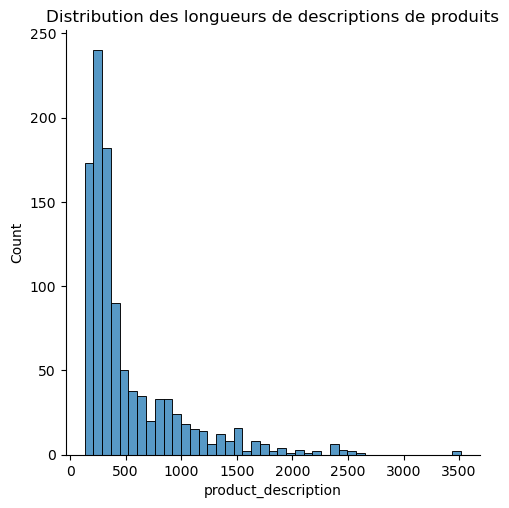

In [14]:
# Création du graphique displot
g = sns.displot(texte.product_description.str.len(), kind="hist")

# Ajout d'un titre
plt.title("Distribution des longueurs de descriptions de produits")

# Affichage du graphique
plt.show()

In [15]:
texte.product_description.str.len().max()

3519

**Catégories**

In [16]:
texte.product_category_tree.value_counts()

product_category_tree
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

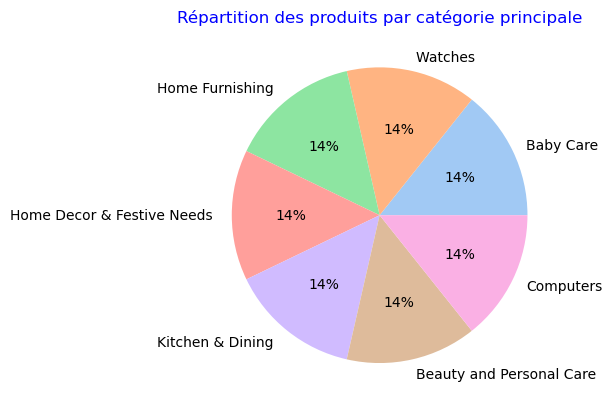

In [17]:
mylabels = ["Baby Care ", "Watches ", "Home Furnishing ", "Home Decor & Festive Needs ", "Kitchen & Dining ", "Beauty and Personal Care ", "Computers"]
y=texte.groupby('product_category_tree').count()['uniq_id'].sort_values(ascending=True)[:7]
colors = sns.color_palette('pastel') [0:7]
plt.title('Répartition des produits par catégorie principale', fontsize=12, color="blue")
plt.pie(y, labels = mylabels, colors = colors, autopct='%.0f%%')
plt.rcParams.update({'font.size': 8})
plt.show()

# <a name="C14">1.4 Prétraitement des données textuelles</a>

**Etapes du prétraitemement**

1- Normalisation: mise en minuscules 

2- tokenisation (avec suppression des caractères non-alphabétiques)

3- suppression des stopwords

4- stemming ou lemmatisation

**Définition des sous-fonctions de prétraitemement**

In [18]:
def tokenize_doc (doc) :
    """ 
    Fonction qui tokenize un document et supprime la ponctuation (en ne gardant que les token alphabetiques)
    arg doc
    return tokens: document tokenisé
    """
    #tokenizer=RegexpTokenizer(r'[a-z]\w+')
    tokens=word_tokenize(doc)
    tokens=[token for token in tokens if token.isalpha()] #le token doit etre alphabetique
    
    return tokens

In [19]:
def remove_stopwords (tokens) :
    """
    Fonction qui supprime les stopwords anglais d'une liste de tokens
    arg tokens: liste de tokens
    return la liste de tokens sans les stopwords anglais
    """
    stop_words=stopwords.words('english')
    tokens= [w for w in tokens if w not in stop_words]
    return tokens

In [20]:
def stemming (tokens) :
    """
    Fonction qui stemme une liste de tokens (supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.)
    arg tokens: liste de tokens
    return la liste de tokens après stemming
    """
    stemmer=PorterStemmer()
    tokens_stemmed=[stemmer.stem(word) for word in tokens]
        
    return tokens_stemmed

In [21]:
def lemmat (tokens) :
    """
    Fonction qui lemmatise une liste de tokens (plus lent que le stemming car nécessite d'utiliser un dictionnaire.)
    arg tokens: liste de tokens
    return la liste de tokens après lemmatisation
    """
    lem=WordNetLemmatizer()
    tokens_lemmatized=[lem.lemmatize(word) for word in tokens]
        
    return tokens_lemmatized

**Définition de la fonction principale de prétraitemement**

In [22]:
def preprocess_doc (doc, stem_or_lem='lem', min_len_word=3) :
    """
    Fonction qui pretraite un document:
    - mise en minuscule
    - tokenisation avec suppression caractères non alphabétiques
    - suppression des stopwords anglais
    - suppression des mots courts
    - stemming ou lemmatisation
    
    arguments:
    -------------
    doc: str: document à pretraiter
    
    optionnal arg:
    -------------
    stem_or_lem: str: si 'stem' => stemming, sinon => lemmatisation
    min_len_word: int: taille minimale des mots
    
    
    
    return tokens: str: doc pré-traité
    """
    # Mise en minuscules
    doc_lowered=doc.lower()
    
    # Tokenisation
    tokens=tokenize_doc(doc_lowered)
    
    # Suppression des stopwords et des mots de longueur < à min_len_word
    tokens_cleaned=remove_stopwords(tokens)
    tokens_min=[w for w in tokens_cleaned if len(w)>=min_len_word]
    
    # Stemming ou lemmatisation
    if stem_or_lem == 'stem' :
        tokens_stem_or_lem=stemming(tokens_min)
    else : 
        tokens_stem_or_lem=lemmat(tokens_min)
    
    return " ".join(tokens_stem_or_lem)

**pré-traitemement du dataframe texte**

In [23]:
texte

,uniq_id,product_description,product_category_tree,category_numeric_true
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,2
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,2
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,2
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker Wallman...,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker Buy Wa...,Baby Care,0


In [24]:
texte["preprocessed_product_description"]=texte.product_description.apply(preprocess_doc)

**Vérification du prétraitemement pour le 1er article**

In [25]:
texte['preprocessed_product_description'][0]

'elegance polyester multicolor abstract eyelet door curtain key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look curtain made high quality polyester feature eyelet style stitch metal make room environment romantic curtain wrinkle anti shrinkage elegant home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model color multicolor dimension length box number content sale package pack

# <a name="C15">1.5 Extraction des features texte</a>

# <a name="C151">1.5.1 Approches de type bag-of-words</a>

Une représentation bag-of-words: chaque document représenté par un vecteur de la taille du vocabulaire  |V|
et on utilisera la matrice composée de l’ensemble de ces N documents qui forment le corpus comme entrée de nos algorithmes.

In [26]:
texte

,uniq_id,product_description,product_category_tree,category_numeric_true,preprocessed_product_description
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,2,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,0,sathiyas cotton bath towel specification sathi...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,0,eurospa cotton terry face towel set key featur...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,2,santosh royal fashion cotton printed king size...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,2,jaipur print cotton floral king sized double b...
...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0,oren empower extra large self adhesive sticker...
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker Wallman...,Baby Care,0,wallmantra large vinyl sticker sticker wallman...
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,0,uberlyfe extra large pigmented polyvinyl film ...
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker Buy Wa...,Baby Care,0,wallmantra medium vinyl sticker sticker buy wa...


# <a name="C1511">1.5.1.1 Comptage simple de mots</a>

In [27]:
corpus=texte['preprocessed_product_description']
vectorizer = CountVectorizer(min_df=2) #seuil min=2 occurences d'un mot dans le corpus (4739 -> 1988)
X_CountVect = vectorizer.fit_transform(corpus)
features=vectorizer.get_feature_names_out()
df_CountVect = pd.DataFrame.sparse.from_spmatrix(X_CountVect, columns=features)

In [28]:
df_CountVect

,aapno,ability,able,abode,absorbency,absorbent,abstract,accent,access,accessory,...,yet,york,young,youth,youthful,yuva,zero,zipper,zone,zyxel
0,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Vérification des 5 premières étapes pour comptage simple**

Le mot 'abstract' est bien présent 5 fois dans la product_description du 1er produit

In [29]:
X_CountVect

<1050x1988 sparse matrix of type '<class 'numpy.int64'>'
	with 29417 stored elements in Compressed Sparse Row format>

# <a name="C1512">1.5.1.2 TF-idf</a>

- Approche BOW permettant de représenter les mots d’un document à l’aide d’une matrice de nombres.

- Pondération: Importance des mots qui apparaissent de temps en temps mais pas trop, tout en en limitant l’importance des mots qui apparaissent souvent.

In [30]:
corpus=texte['preprocessed_product_description']
vectorizer = TfidfVectorizer(min_df=2) #seuil min=2 occurences d'un mot dans le corpus (4739 -> 1988)
X_Tfidf = vectorizer.fit_transform(corpus)
features=vectorizer.get_feature_names_out()
df_Tfidf=pd.DataFrame.sparse.from_spmatrix(X_Tfidf, columns=features)

In [31]:
df_Tfidf

,aapno,ability,able,abode,absorbency,absorbent,abstract,accent,access,accessory,...,yet,york,young,youth,youthful,yuva,zero,zipper,zone,zyxel
0,0,0,0,0,0,0,0.200871,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0.068707,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Avec TfIDF, le mot 'abstract' est pondéré à 0.2

# <a name="C152">1.5.2 Approches de type word embedding</a>

# <a name="C1521">1.5.2.1 Word2Vec</a>

- Word2Vec est une représentation dans laquelle le mot possède une représentation dans un espace qui le positionne en fonction des mots adjacents

- Représentation des mots dans un espace avec une forme de similarité entre eux (c'est-à-dire probabiliste), dans lesquels le sens des mots les rapproche dans cet espace, en terme de distances statistiques
                                                                                 
- C’est un plongement dans un espace de dimension inférieur autour de 20-100 dimensions généralement.

Word2Vec propose d'apprendre des représentations vectorielles de mots présents dans un corpus en utilisant des reseaux de neurones

In [32]:
w2v_size=100 #taille des vecteurs de mots générés par Word2Vec (dimension=100)
w2v_window=5 # les 5 mots précédents et les 5 mots suivants sont pris en compte
w2v_min_count=5 # nombre minimum d’occurrences d’un mot pour qu’il soit pris en compte dans le modèle (valeur par défaut=5)
w2v_epochs=100 # nombre de fois où le modèle parcourt le corpus de texte pendant l’entraînement. Dans ce cas, 100 itérations seront effectuées
maxlen = 3519 # longueur maximale de product_description, ce serait aussi le nb de colonne de x_sentences
sentences = texte['preprocessed_product_description'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [33]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
#w2v_model = Word2Vec()
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window, vector_size=w2v_size)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs) #If you've just built the vocabulary using the same corpus, using the count cached in the model is sufficient: total_examples=model.corpus_count.
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 1573
Word2Vec trained


In [34]:
w2v_model.wv.most_similar("laptop")

[('mouse', 0.5396033525466919),
 ('pad', 0.4984666407108307),
 ('headphone', 0.44631001353263855),
 ('mary', 0.4401707649230957),
 ('compatible', 0.4355596601963043),
 ('pavilion', 0.4087338149547577),
 ('roronoa', 0.4069923162460327),
 ('power', 0.4050520658493042),
 ('rega', 0.40407291054725647),
 ('max', 0.40094655752182007)]

In [35]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4266


In [36]:
x_sentences

array([[ 677,  112,   52, ...,    0,    0,    0],
       [1577,   21,  134, ...,    0,    0,    0],
       [1064,   21,  710, ...,    0,    0,    0],
       ...,
       [1385,  641,  385, ...,    0,    0,    0],
       [ 426,  297,  236, ...,    0,    0,    0],
       [1385,  385,  236, ...,    0,    0,    0]])

In [37]:
x_sentences.shape

(1050, 3519)

In [38]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():   # i: Nombre de mots uniques: 4266 (dans tout le corpus)
    i +=1
    if word in w2v_words:              # j: Taille du vacabulaire pour w2v_model: 1573 (seulement les mots présents au moins 5 fois)
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.3688
Embedding matrix: (4266, 100)


In [39]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3519)]            0         
                                                                 
 embedding (Embedding)       (None, 3519, 100)         426600    
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 426600 (1.63 MB)
Trainable params: 426600 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# Exécution du modèle
X_W2VEC = embed_model.predict(x_sentences)
X_W2VEC.shape

33/33 [==============================] - 1s 11ms/step


(1050, 100)

# <a name="C1522">1.5.2.2 BERT</a>

- BERT: Bidirectional Encoder Representations from Transformers
    
- BERT: Google AI fin 2018

- Une fois pré-entraîné, de façon non supervisée (initialement avec le corpus anglophone de Wikipedia), il possède une "représentation" linguistique qui lui est propre. Il est ensuite possible, sur la base de cette représentation initiale, de le customiser pour une tâche particulière. Il peut être entraîné en mode incrémental (de façon supervisée cette fois) pour spécialiser le modèle rapidement et avec peu de données.

In [41]:
#max_length = 64 => ARI=0.3073
#max_length (int, optional, defaults to 512) — The maximum length of the sequence, used for padding (if padding is “max_length”) and/or truncation (if truncation is True).
# max_length=512 => ARI=0.25
os.environ["TF_KERAS"]='1'
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
corpus=texte['preprocessed_product_description']
sentences = corpus.to_list()


loading configuration file config.json from cache at C:\Users\Vincent-Formation\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\Vincent-Formation\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e093

In [42]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    # Features BERT
    X_BERT = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return X_BERT, last_hidden_states_tot

In [43]:
X_BERT, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\Vincent-Formation\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\Vincent-Formation\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12

1/1 [==============================] - 1s 517ms/step
temps traitement :  93.0


In [44]:
X_BERT.shape

(1050, 768)

# <a name="C1523">1.5.2.3 USE</a>

- USE (Universal Sentence Encoder) encode du texte en un vecteur de grande dimension

- The model USE est entrainé 

- Entrée de USE du texte anglais (longueur variable), la sortie: un vecteur de dimension 512 

In [45]:
os.environ["TF_KERAS"]='1'

In [46]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [47]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [48]:
batch_size = 10
corpus=texte['preprocessed_product_description']
sentences = corpus.to_list()

In [49]:
# Features USE
X_USE = feature_USE_fct(sentences, batch_size)
X_USE.shape

(1050, 512)

# <a name="C16">1.6 Modélisation LDA - détection de catégories</a>

- LDA est une méthode non supervisée de modélisation automatique de sujet

- LDA permet de détecter les sujets latents abordés dans un corpus de documents

- C’est aussi une famille de méthode utilisé essentiellement en exploration voire semi-supervisée, c’est à dire qui permet de détecter si effectivement il y a de grandes catégories abordées, et ensuite les affiner lors du passage en production, et supervision des nouveaux documents entrants.

In [50]:
tmp=texte['preprocessed_product_description']
tmp

0       elegance polyester multicolor abstract eyelet ...
1       sathiyas cotton bath towel specification sathi...
2       eurospa cotton terry face towel set key featur...
3       santosh royal fashion cotton printed king size...
4       jaipur print cotton floral king sized double b...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker wallman...
1047    uberlyfe extra large pigmented polyvinyl film ...
1048    wallmantra medium vinyl sticker sticker buy wa...
1049    uberlyfe large vinyl sticker buy uberlyfe larg...
Name: preprocessed_product_description, Length: 1050, dtype: object

In [51]:
tokens = tmp.str.split()

Quelques catégories qui ont été modélisées sont effectivement interprétables : 

- La catégorie 5 représente globalement les "computers"

- La catégorie 6 représente globalement le "baby care"

In [52]:
tokens

0       [elegance, polyester, multicolor, abstract, ey...
1       [sathiyas, cotton, bath, towel, specification,...
2       [eurospa, cotton, terry, face, towel, set, key...
3       [santosh, royal, fashion, cotton, printed, kin...
4       [jaipur, print, cotton, floral, king, sized, d...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, w...
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048    [wallmantra, medium, vinyl, sticker, sticker, ...
1049    [uberlyfe, large, vinyl, sticker, buy, uberlyf...
Name: preprocessed_product_description, Length: 1050, dtype: object

In [53]:
# Conversion a collection of words to a bag of words, which is a list of tuples (word_id, word_frequency). gensim.corpora.Dictionary is a great tool for this:
id2word = Dictionary(tokens)
len(id2word)

4268

In [54]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tokens]
print(corpus[:1])

[[(0, 5), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 12), (18, 2), (19, 1), (20, 1), (21, 6), (22, 2), (23, 5), (24, 2), (25, 1), (26, 1), (27, 1), (28, 7), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 2), (54, 5), (55, 1), (56, 1), (57, 3), (58, 2), (59, 7), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)]]


In [55]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

[[('abstract', 5),
  ('amount', 1),
  ('anti', 1),
  ('apart', 1),
  ('appeal', 1),
  ('attention', 1),
  ('beauty', 1),
  ('body', 1),
  ('box', 1),
  ('brand', 1),
  ('bright', 2),
  ('bring', 1),
  ('close', 1),
  ('color', 1),
  ('contemporary', 1),
  ('content', 1),
  ('create', 1),
  ('curtain', 12),
  ('design', 2),
  ('designed', 1),
  ('dimension', 1),
  ('door', 6),
  ('draw', 2),
  ('elegance', 5),
  ('elegant', 2),
  ('enhances', 1),
  ('environment', 1),
  ('evening', 1),
  ('eyelet', 7),
  ('feature', 2),
  ('filter', 1),
  ('first', 1),
  ('floral', 1),
  ('general', 1),
  ('get', 1),
  ('given', 1),
  ('good', 1),
  ('heart', 1),
  ('height', 2),
  ('high', 1),
  ('home', 2),
  ('joyous', 1),
  ('key', 1),
  ('length', 1),
  ('light', 1),
  ('look', 1),
  ('made', 1),
  ('make', 1),
  ('material', 1),
  ('metal', 1),
  ('model', 2),
  ('modernistic', 1),
  ('moment', 1),
  ('morning', 2),
  ('multicolor', 5),
  ('name', 1),
  ('number', 1),
  ('pack', 3),
  ('package', 

In [56]:
# Build an LDA topic model. We will use gensim.models.ldamodel.LdaModel for this
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=7,
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.038*"baby" + 0.022*"fabric" + 0.021*"cotton" + 0.020*"detail" + '
  '0.020*"boy" + 0.020*"girl" + 0.016*"print" + 0.014*"general" + 0.014*"pack" '
  '+ 0.013*"specification"'),
 (1,
  '0.032*"watch" + 0.026*"woman" + 0.023*"dark" + 0.022*"showpiece" + '
  '0.020*"product" + 0.017*"india" + 0.017*"collection" + 0.017*"great" + '
  '0.016*"lip" + 0.016*"sticker"'),
 (2,
  '0.025*"shape" + 0.020*"pack" + 0.019*"laptop" + 0.018*"inch" + '
  '0.018*"sticker" + 0.017*"color" + 0.015*"wall" + 0.014*"easy" + '
  '0.013*"light" + 0.013*"number"'),
 (3,
  '0.095*"skin" + 0.033*"polyester" + 0.028*"eyelet" + 0.024*"curtain" + '
  '0.020*"single" + 0.020*"multicolor" + 0.019*"design" + 0.019*"door" + '
  '0.018*"combo" + 0.017*"home"'),
 (4,
  '0.061*"pad" + 0.060*"mouse" + 0.039*"mug" + 0.033*"double" + '
  '0.032*"ceramic" + 0.029*"print" + 0.018*"red" + 0.012*"blanket" + '
  '0.011*"price" + 0.011*"safe"'),
 (5,
  '0.062*"free" + 0.057*"product" + 0.055*"delivery" + 0.055*"shipping" +

In [57]:
pyLDAvis.enable_notebook()

# Replace 'lda_model', 'corpus', and 'lda_model.id2word' with your actual model and data
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.149389  0.083178       1        1  23.152058
5      0.311328  0.041789       2        1  18.582677
0     -0.152232  0.134932       3        1  17.127892
6     -0.157265  0.056494       4        1  13.567162
4      0.008013 -0.214878       5        1  11.230414
3     -0.086455 -0.171241       6        1   8.942307
1      0.226000  0.069727       7        1   7.397490, topic_info=            Term        Freq       Total Category  logprob  loglift
143         skin  498.000000  498.000000  Default  30.0000  30.0000
212     shipping  605.000000  605.000000  Default  29.0000  29.0000
205      genuine  605.000000  605.000000  Default  28.0000  28.0000
200         cash  604.000000  604.000000  Default  27.0000  27.0000
202     delivery  608.000000  608.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
203     discount   33.396309   95.757114   Topic7  -4.8322   1.5507
201          day   54.933047  489.670497   Topic7  -4.3345   0.4164
211  replacement   45.351411  487.035613   Topic7  -4.5262   0.2301
204         free   36.832695  761.386122   Topic7  -4.7342  -0.4247
199          buy   32.760605  616.404237   Topic7  -4.8514  -0.3306

[413 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.258383  abstract
0         6  0.738238  abstract
444       4  0.936835       air
2079      6  0.944835    almond
1059      1  0.085646   amazing
...     ...       ...       ...
89        6  0.948837     world
89        7  0.035142     world
646       5  0.625277     would
646       6  0.367010     would
2489      3  0.975896     woven

[904 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 7, 5, 4, 2])

# <a name="C17">1.7 Regroupement et visualisation des catégories</a>

Etapes pour chaque type de feature extraction

1- Réduction en 2D avec T-SNE

2- Clustering K-Means

3- Calcul ARI

4- Visualisation des catégories

 # <a name="C171">1.7.1 Fonctions communes</a>

In [58]:
def TSNE_KMEANS_ARI(features):
    
    # T-SNE avec 2 composantes:
    X_TSNE = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(features)

    # Clustering K-Means (K=7)
    cls = KMeans(n_clusters=7, init='k-means++', random_state=42)
    cls.fit(X_TSNE)

    # Calcul de l'ARI
    ARI=metrics.adjusted_rand_score(texte['category_numeric_true'], cls.labels_)

    return X_TSNE, cls, ARI

In [59]:
def display_clusters(X_TSNE, cls, ARI):
    fig = plt.figure(figsize=(15,6))
    l_cat=[0,1,2,3,4,5,6]
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_TSNE[:,0],X_TSNE[:,1], c=texte["category_numeric_true"], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie", fontsize=6)
    plt.title('Categorie_True: après Feature extract avec ...')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_TSNE[:,0],X_TSNE[:,1], c=cls.labels_, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie_KMeans", fontsize=6)
    plt.title('Categories_Pred (KMeans) après Feature extract avec ...')
    
    plt.show()
    print("ARI : ", ARI)

 # <a name="C172">1.7.2 Regroupement et représentation des articles</a>

Calcul de l'ARI et affichage des résultats pour chaque type de feature extraction

**Feature extraction: BOW comptage simple**

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) o

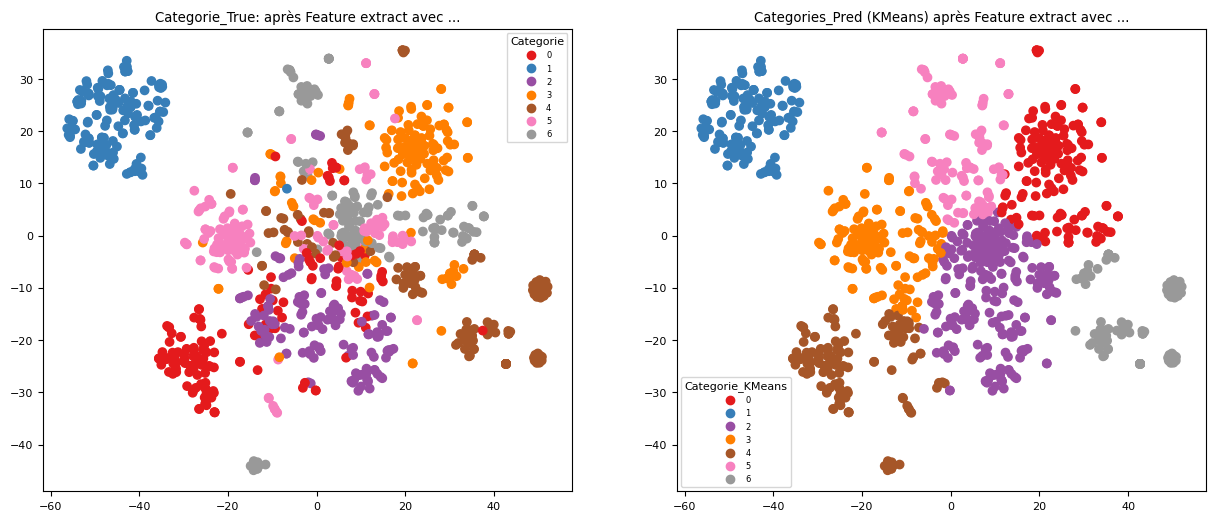

ARI :  0.3674220082908344


In [60]:
X_TSNE_CountVect, cls_CountVect, ARI_CountVect=TSNE_KMEANS_ARI(X_CountVect)
display_clusters(X_TSNE_CountVect, cls_CountVect, ARI_CountVect)

**Feature extraction: BOW Tfidf**

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) o

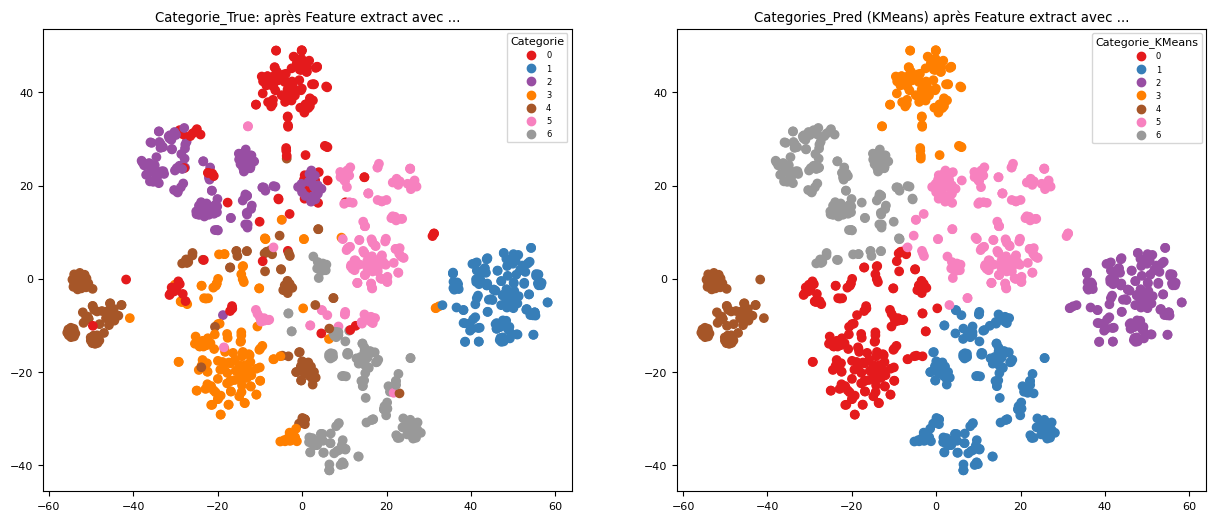

ARI :  0.5717976065077922


In [61]:
X_TSNE_Tfidf, cls_Tfidf, ARI_Tfidf=TSNE_KMEANS_ARI(X_Tfidf)
display_clusters(X_TSNE_Tfidf, cls_Tfidf, ARI_Tfidf)

**Feature extraction: Word Embedding Word2Vec**

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) o

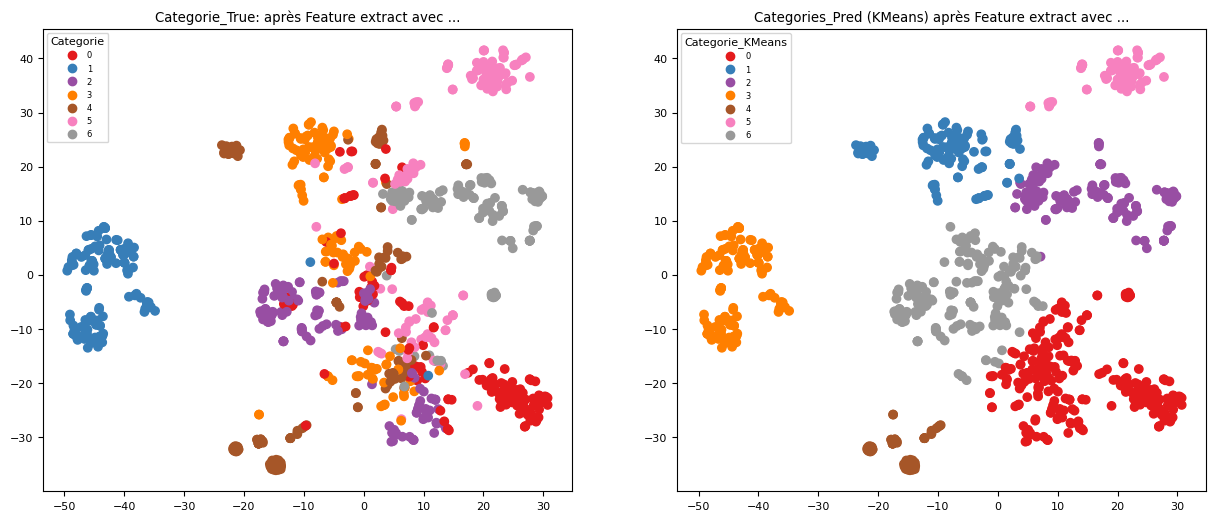

ARI :  0.4013163028183037


In [62]:
X_TSNE_W2VEC, cls_W2VEC, ARI_W2VEC=TSNE_KMEANS_ARI(X_W2VEC)
display_clusters(X_TSNE_W2VEC, cls_W2VEC, ARI_W2VEC)

**Feature extraction: Word Embedding BERT**

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) o

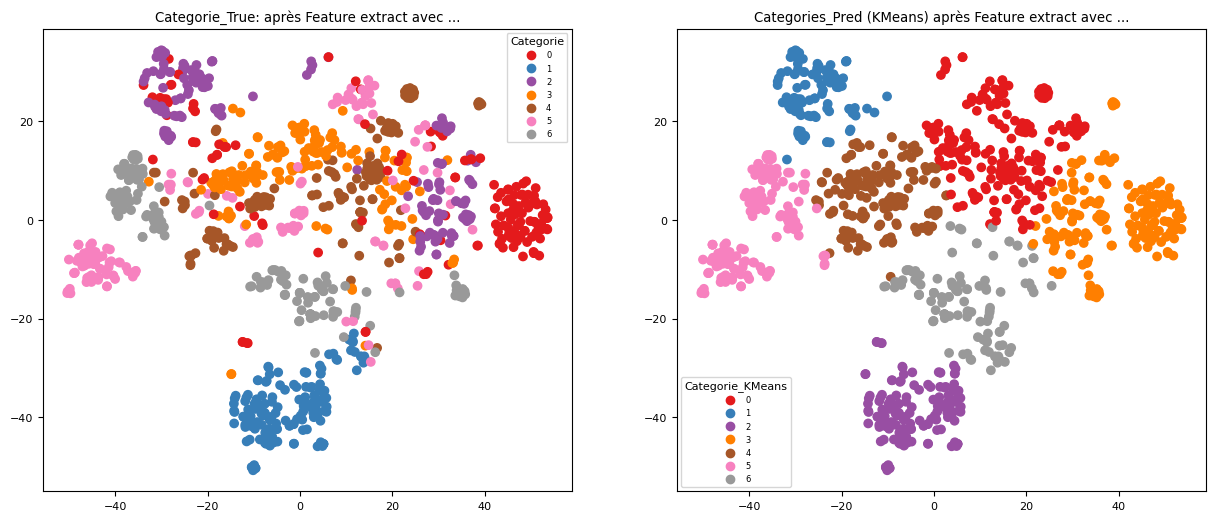

ARI :  0.33642900566637973


In [63]:
X_TSNE_BERT, cls_BERT, ARI_BERT=TSNE_KMEANS_ARI(X_BERT)
display_clusters(X_TSNE_BERT, cls_BERT, ARI_BERT)

**Feature extraction: Word Embedding USE**

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) o

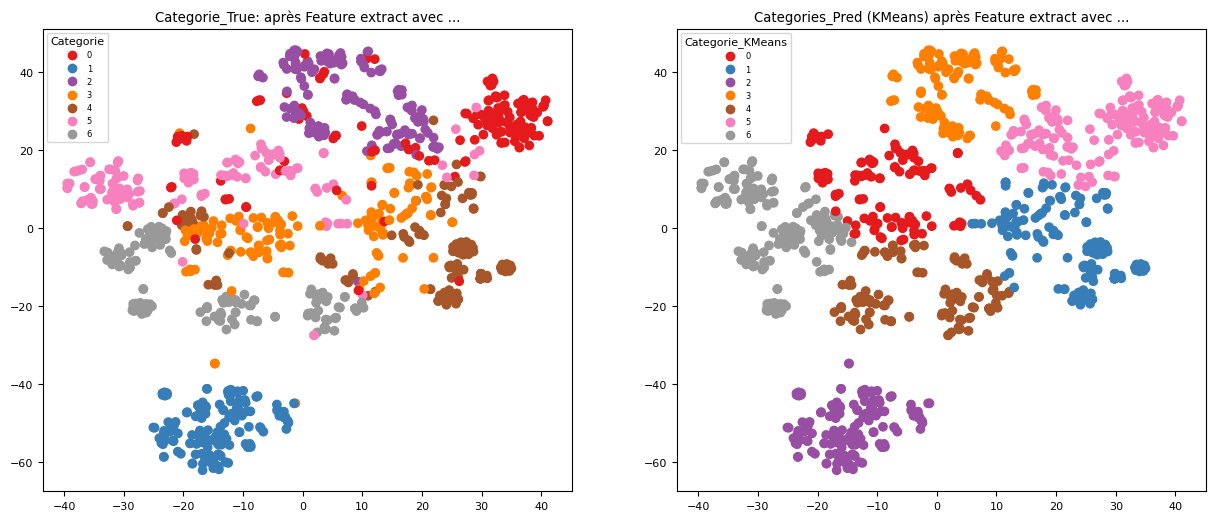

ARI :  0.439039809927707


In [64]:
X_TSNE_USE, cls_USE, ARI_USE=TSNE_KMEANS_ARI(X_USE)
display_clusters(X_TSNE_USE, cls_USE, ARI_USE)

 # <a name="C173">1.7.3 Comparaison des résultats</a>

In [65]:
data = [['BOW comptage simple', 'alpha_only, minocc=3', '1988', 'T-SNE', 'K-Means', ARI_CountVect],
        ['BOW Tfidf', 'alpha_only, minocc=3', '1988', 'T-SNE', 'K-Means', ARI_Tfidf],
        ['Word Embedding: Word2Vec', 'W2Vecminocc=5', '100', 'T-SNE', 'K-Means', ARI_W2VEC],
        ['Word Embedding: BERT', '','768', 'T-SNE', 'K-Means', ARI_BERT],
        ['Word Embedding: USE', '', '512', 'T-SNE', 'K-Means', ARI_USE]]

df = pd.DataFrame(data, columns=['Feature extraction', 'Pretraitement','Nombre de features', 'Réduction dimension', 'Classification', 'ARI'])
df

,Feature extraction,Pretraitement,Nombre de features,Réduction dimension,Classification,ARI
0,BOW comptage simple,"alpha_only, minocc=3",1988,T-SNE,K-Means,0.367422
1,BOW Tfidf,"alpha_only, minocc=3",1988,T-SNE,K-Means,0.571798
2,Word Embedding: Word2Vec,W2Vecminocc=5,100,T-SNE,K-Means,0.401316
3,Word Embedding: BERT,,768,T-SNE,K-Means,0.336429
4,Word Embedding: USE,,512,T-SNE,K-Means,0.439040


**La feature extraction Tfidf permet d'obtenir le meilleur score ARI, suivi de USE**

# <a name="C2">Partie 2: Faisabilité classification des images</a>

# <a name="C21">2.1 Imports</a>

In [66]:
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import time
import numpy as np

# OpenCV
import cv2

from sklearn import manifold, decomposition

# ProductId_Main_Categ.csv
Images_MainCateg=pd.read_csv('ProductId_Main_Categ.csv') 

# <a name="C22">2.2 Nettoyage des données image</a>

**Récupération de la main catégorie**

In [67]:
Images_MainCateg

,uniq_id,product_description,product_category_tree,category_numeric_true
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,2
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,2
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,2
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker Wallman...,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker Buy Wa...,Baby Care,0


In [68]:
data=Images_MainCateg.sort_values(by='uniq_id')

In [69]:
data.reset_index(drop=True, inplace=True)

In [70]:
data

,uniq_id,product_description,product_category_tree,category_numeric_true
0,009099b1f6e1e8f893ec29a7023153c4,"palito PLO 166 Analog Watch - For Girls, Wome...",Watches,1
1,0096e89cc25a8b96fb9808716406fe94,oxford Tawa 15 cm cm diameter Key Features of ...,Kitchen & Dining,4
2,00cbbc837d340fa163d11e169fbdb952,Flazee Home Trends Beige 144.78 cm Table Runne...,Home Furnishing,2
3,00d84a518e0550612fcfcba3b02b6255,Mxofere Combo Rose Soap And Aloevera Lemon Fac...,Beauty and Personal Care,5
4,00e966a5049a262cfc72e6bbf68b80e7,YGS Keyboard Case for Asus Memo Pad 7in Tab Ke...,Computers,6
...,...,...,...,...
1045,feefbdff924dd6b7cc266449c9a36d69,Rockmantra Red Flowers In Bucket Ceramic Mug R...,Kitchen & Dining,4
1046,ff24511994fc459d04145231c8876d6c,"Home Originals Polka, Abstract Double Blanket ...",Home Furnishing,2
1047,ffbf3794aa8cb6bb8d3f313d0a549a09,Returnfavors Cartoon shaped Coffee For Kids Ce...,Kitchen & Dining,4
1048,ffc2e1fc7c886ec09a331040ada038aa,Raymond Abstract Double Blanket Grey Buy Raymo...,Home Furnishing,2


In [71]:
data['product_category_tree']

0                        Watches 
1               Kitchen & Dining 
2                Home Furnishing 
3       Beauty and Personal Care 
4                      Computers 
                  ...            
1045            Kitchen & Dining 
1046             Home Furnishing 
1047            Kitchen & Dining 
1048             Home Furnishing 
1049                   Computers 
Name: product_category_tree, Length: 1050, dtype: object

In [72]:
data['uniq_id'] = data['uniq_id'] + '.jpg'

In [73]:
data.shape

(1050, 4)

In [74]:
data.to_csv('data_category.csv',index=False)

# <a name="C23">2.3 Prétraitement</a>

- Passage en niveau de gris
- Egalisation de l'histogramme pour augmenter netteté de l'image

**Affichage d'une image originale avec Matplotlib**

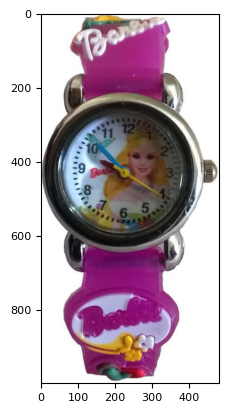

In [75]:
image = imread("Images/22146eaca9aee0223a4302d87cb3e122.jpg")
plt.imshow(image)

In [76]:
image.shape

(1000, 480, 3)

**Passage en niveau de gris avec openCV**

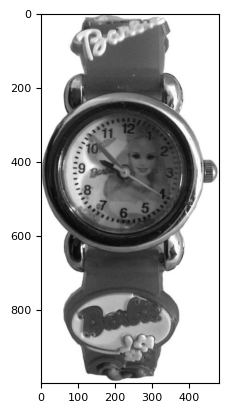

In [77]:
img = cv2.imread('Images/22146eaca9aee0223a4302d87cb3e122.jpg', cv2.IMREAD_COLOR)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gris)
plt.imshow(img_gris,'gray')

In [78]:
img_gris.shape

(1000, 480)

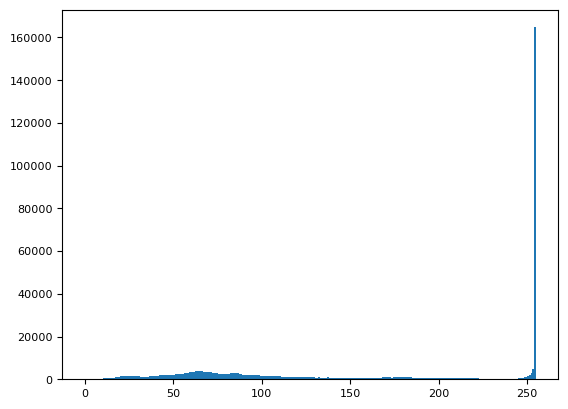

In [79]:
n, bins, patches = plt.hist(img_gris.flatten(), bins=range(256))
plt.show()

**Egalisation histo (pour augmenter netteté image)**

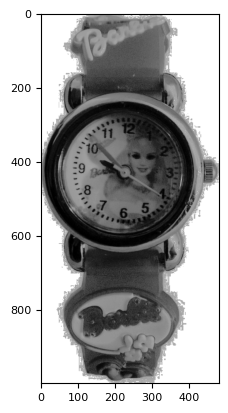

In [80]:
img_equalized = cv2.equalizeHist(img_gris)
plt.imshow(img_equalized,'gray')

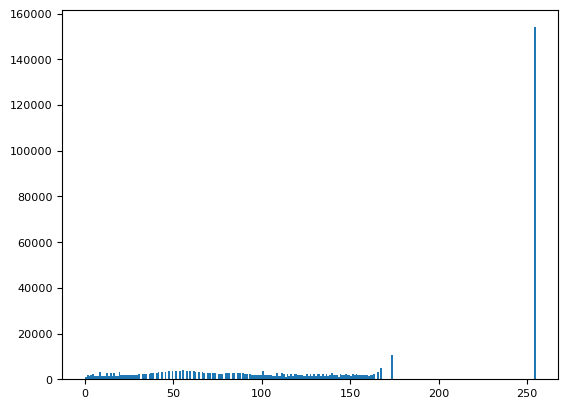

In [81]:
img_equalized = cv2.equalizeHist(img_gris)
n, bins, patches = plt.hist(img_equalized.flatten(), bins=range(256))
plt.show()

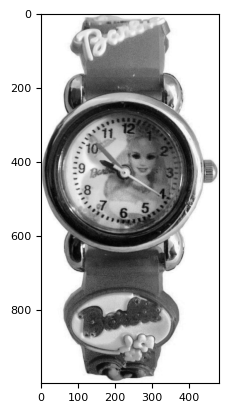

In [82]:
# Egalisation histo méthode CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
img_equal_clahe = clahe.apply(img_gris)
plt.imshow(img_equal_clahe,'gray')

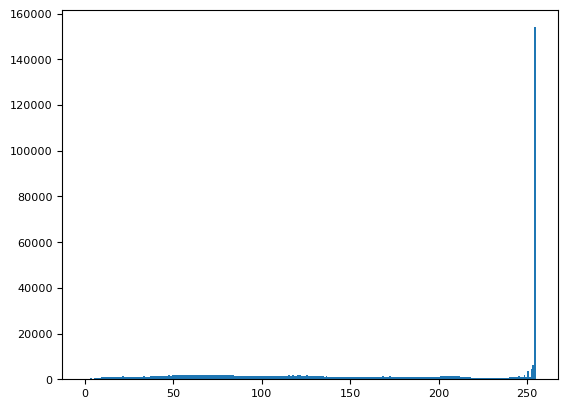

In [83]:
n, bins, patches = plt.hist(img_equal_clahe.flatten(), bins=range(256))
plt.show()

**La méthode d'égalisation CLAHE permet d'obtenir une meilleur netteté d'image**

In [84]:
def preprocess_image():
    """
    Fonction qui prétraite une image en 3 étapes:
    - Etape 1: Passage en niveau de gris avec openCV 
    - Etape 2: Egalisation d'histogramme avec la méthode CLAHE
    - Etape 3: Écriture de l'image prétraitée dans un fichier du répertoire Preprocessed_Images
     """
    input_folder = "Images/"
    output_folder = "Preprocessed_Images/"
    list_image_name = [file for file in listdir(input_folder)]
       
    # Parcourir la liste des noms de fichiers
    nb_images_pretraitees=0
    for image_name in list_image_name:
        
        # Lecture de l'image d'origine 
        image_path = input_folder + image_name
        im = cv2.imread(image_path)
        
        #Passage en niveau de gris avec openCV
        im_gris = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        # Egalisation d'histogramme avec la méthode CLAHE pour améliorer la qualité des images
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
        img_gris_equal = clahe.apply(im_gris)

        # Écriture de l'image redimensionnée dans un fichier du répertoire Preprocessed_Images
        output_path = output_folder + image_name
        cv2.imwrite(output_path, img_gris_equal)
        nb_images_pretraitees+=1
    
    print("Nombre d'images prétraitées:", nb_images_pretraitees) 

In [85]:
preprocess_image()

Nombre d'images prétraitées: 1050


# <a name="C24">2.4 Faisabilité de la classification d'images avec SIFT</a>

- Algorithme SIFT (Scale-invariant feature transform)

- Cette méthode, développée en 1999 et très populaire dans le domaine de la vision par ordinateur

- Permet d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs **descripteurs**

- Un descripteur SIFT est composé de 128 valeurs entières

- Image codée par un bag of features (analogie descripteurs <=> mots)

- Clustering k-means: les visual words seront les centres de ces clusters

# <a name="C241">2.4.1 Extraction des features d'une image avec SIFT</a>

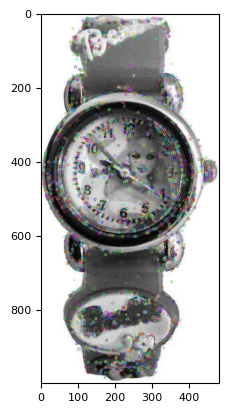

Descripteurs :  (2188, 128)

[[137.   5.   0. ...   0.   0.   0.]
 [147.  14.   0. ...   0.   0.   3.]
 [148.  17.   0. ...   0.   0.   0.]
 ...
 [ 20.  23.  30. ...   0.   0.  59.]
 [142.  22.   0. ...   0.   0.   4.]
 [  9.  90.  30. ...   0.   0.  11.]]


In [86]:
sift=cv2.SIFT_create()
kp, des = sift.detectAndCompute(img_equal_clahe, None)
img=cv2.drawKeypoints(img_equal_clahe,kp,img_equal_clahe)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

- L'image contient 2188 descripteurs

- Chaque descripteur est un vecteur de longueur 128

# <a name="C242">2.4.2 Extraction des features de l'ensemble des images avec SIFT</a>

**Créations des descripteurs de chaque image**

In [87]:
path = "Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [88]:
list_photos

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '00ed03657cedbe4663eff2d7fa702a33.jpg',
 '01089dc3618a0ab7304d784ef400b83d.jpg',
 '0131e5d87b72877702d536299cf83b75.jpg',
 '020d2daba55a723128e4e07c0b0393a9.jpg',
 '02127f52e96fb72c66bf081d25104ef8.jpg',
 '025a85a3d1cddc6307f7dc075d8d2132.jpg',
 '02a53d335775b652f22f41b529b9d646.jpg',
 '02c63a087b298ec74042d557acf61be1.jpg',
 '031c98cfde349d99fb6d5983f54c8751.jpg',
 '032e812adcd11a38fd8b764891a852ff.jpg',
 '037b39bef3db7ccd264c577a0edf0c0a.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '04f9f818e2d657b873b07578cfe2eade.jpg',
 '04f9ff160a1561e3656350f4bd6b8c50.jpg',
 '050ea3acb555bf641e7ae9b4f3ba684a.jpg',
 '052559ede419996737893eb47568ee7f.jpg',
 '057836ecde71565f8ebdd576e41fdc96.jpg',
 '059493eeb88ebb4cc08d1522f3f87c3f.jpg',
 '059bc43e03e1824a9ab6466e32e5f137.jpg',
 '06749cbff1487f

In [89]:
# Identification des key points et des descripteurs associés

sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    # conversion en gris
    image = cv2.imread(path+list_photos[image_num],0) 
    
    # egalisation d'histogramme
    res = cv2.equalizeHist(image)   
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

0
100


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 353894400 bytes in function 'cv::OutOfMemoryError'


In [ ]:
sift_keypoints_all    = np.concatenate(sift_keypoints, axis=0)
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

In [ ]:
sift_keypoints

In [ ]:
sift_keypoints_all

**Créations des clusters de descripteurs**

In [ ]:
# Determination number of clusters
temps1=time.time()

# Choix du nombre de descripteurs: racine carrée du nombre de descripteurs
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

**Création des features des images**

In [ ]:
# Creation des histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation d'une matrice d'histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

# <a name="C243">2.4.3 Réduction en 2D</a>

**Réduction de dimension PCA**

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

In [ ]:
feat_pca

**Réduction de dimension T-SNE**

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["product_category_tree"]
print(df_tsne.shape)


In [ ]:
df_tsne

**Category_True: après features extraction SIFT**

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()

Analyse graphique: impossible de séparer les images selon leurs vraies classes

# <a name="C244">2.4.4 Clustering K-Means - Regroupement des produits en catégories</a>

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=0)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

**Category_Pred: après features extraction SIFT**

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["product_category_tree"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Le score ARI très faible de 0.04 confirme l'impossibilité de séparer les images selon leurs vraies classes

# <a name="C25">2.5 Faisabilité de la classification d'images avec CNN Transfer Learning</a>

- VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.

- Il prend en entrée une image en couleurs de taille 224×224 et la classifie dans une des 1000 classes.

# <a name="C251">2.5.1 Création du modèle VGG16</a>

In [ ]:
# Création du modèle pré-entraîné
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

# <a name="C252">2.5.2 Extraction des features images avec VGG16</a>

In [ ]:
#Création des features des images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
path = "Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

images_features = []
i=0 
for image_file in list_photos :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

In [ ]:
list_photos

# <a name="C253">2.5.3 Réduction en 2D</a>

In [ ]:
# Réduction de dimension PCA: on veut garder 99% de la variance expliquée
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

In [ ]:
# Réduction de dimension T-SNE et affichage des images selon vraies classes
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

**Category_True: après extraction de features VGG16**

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["product_category_tree"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()

Analyse graphique: il est possible de séparer les images selon leurs vraies classes

# <a name="C254">2.5.4 Clustering K-Means - Regroupement des produits en catégories</a>

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

**Category_Pred: après extraction de features VGG16**

In [ ]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["product_category_tree"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

**Le score ARI de 0.45 confirme la faisabilité de la classification des images**